### Load data

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [27]:
file_path = "..\data\ALGOUSDT.csv"
df = pd.read_csv(file_path, sep="|", header=None)
print(df.shape)

(2991782, 10)


In [28]:
# set column names
df.columns = ["timestamp", "open", "high", "low", "close", "volume", "Taker Buy Quote Asset Volume", 
              "Taker Buy Base Asset Volume", "Quote Asset Volume", "Number of trades"]

# convert unix timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s', origin='unix')

# set timestamp as index
df = df.set_index("timestamp")

# sort by index
df = df.sort_index()

# display the first five rows
df.head(2)

,open,high,low,close,volume,Taker Buy Quote Asset Volume,Taker Buy Base Asset Volume,Quote Asset Volume,Number of trades
timestamp,,,,,,,,,
2019-06-22 00:00:00,3.40,3.440,2.989,3.150,196437.510,364193.883,113795.25,626516.851,796
2019-06-22 00:01:00,3.15,3.151,3.019,3.039,157708.607,229296.225,73837.53,487567.859,595


In [29]:
df.tail(2)

,open,high,low,close,volume,Taker Buy Quote Asset Volume,Taker Buy Base Asset Volume,Quote Asset Volume,Number of trades
timestamp,,,,,,,,,
2025-03-01 18:09:00,0.2362,0.2364,0.2362,0.2363,8497.0,1312.0,5552.0,2007.0,43
2025-03-01 18:10:00,0.2363,0.2364,0.2362,0.2364,6454.0,1096.0,4638.0,1525.0,42


The dataset contains 1 minute OHLCV data from 22 Jun 2019 to 01 Mar 2025 (2,991,782 records)

In [30]:
def gen_plot(df, title=None):
    plt.figure(figsize=(12, 3))
    plt.plot(df)
    plt.title(title)
    plt.grid()
    plt.show()

### Check Completeness

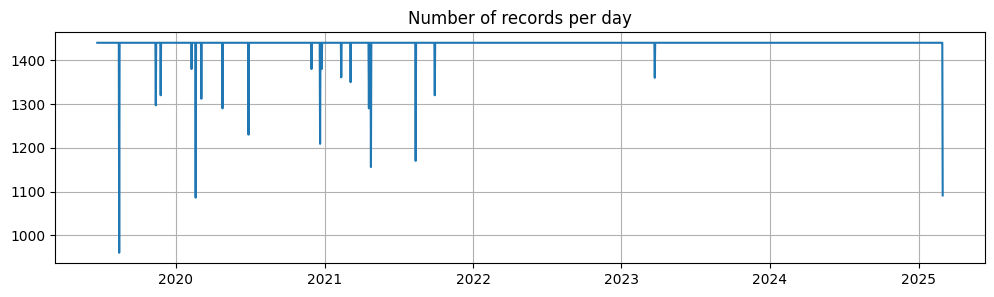

In [31]:
# Calculate number of records per day
count = df['open'].resample('1D').apply(lambda x: x.count())

# Plot the number of records per day
gen_plot(count, "Number of records per day")

In [32]:
# Find days with incomplete records
incomplete_index = count[count != 1440].index
print(incomplete_index, len(incomplete_index))

DatetimeIndex(['2019-08-15', '2019-11-13', '2019-11-25', '2020-02-09',
               '2020-02-19', '2020-03-04', '2020-04-25', '2020-06-28',
               '2020-11-30', '2020-12-21', '2020-12-25', '2021-02-11',
               '2021-03-06', '2021-04-20', '2021-04-25', '2021-08-13',
               '2021-09-29', '2023-03-24', '2025-03-01'],
              dtype='datetime64[ns]', name='timestamp', freq=None) 19


In [33]:
# Drop 2025-03-01 data
df = df[:'2025-02-28']

In [34]:
# find number of days from 2019-06-22 to 2025-02-28
days = len(pd.date_range(start='2019-06-22', end='2025-02-28', freq='D'))
print(days)

2079


#### Imputation

In [35]:
# create a new dataframe for imputed data
df_complete = df.ffill()

# check if there are any missing values
print(df_complete.isnull().sum().sum())

0


### Create Log Return

For $ t = 1, \dots, 2079 $:

$\quad$ For $ n = 1 $:

$$ r_{t,1} = log(p_{t,1}) - log(p_{t-1, 1440}) $$

$\quad$ For $ n = 2, 3, \dots, 1440 $:

$$ r_{t,n} = log(p_{t,n}/p_{t, n-1}) = log(p_{t,n}) - log(p_{t, n-1}) $$

where $p_{t,n}$ is the asset close at the nth minute in time $t$. 

Exception: $r_{1, 1}$ is not defined. 

In [36]:
# construct log return
df_complete['log_return'] = np.log(df_complete['close']).diff()
df_complete = df_complete.dropna()

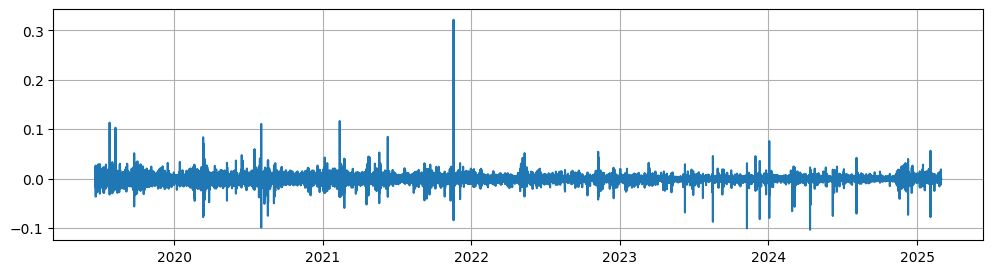

In [37]:
# plot log return
gen_plot(df_complete['log_return'])

In [38]:
# find the date where the log return is maximum
max_return_date = df_complete['log_return'].idxmax()
print(max_return_date)

2021-11-18 04:25:00


- the announced addition of an Algorand exchange-traded product (ETP) in Switzerland

### Resampling to Daily Records

$$ r_t = log(p_t) - log(p_{t-1}) $$

$$ RV_t = \sum_{n=1}^{1440} {r_{t, n}^2} $$

$$ lnRV_t = log(\sum_{n=1}^{1440} {r_{t, n}^2}) $$

In [39]:
# resample to construct a new dataframe for daily OHLC records
df_daily = df_complete.resample('1D').agg({'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last'})

# construct daily (log) return
df_daily['return'] = np.log(df_daily['close']).diff()
df_daily.dropna(inplace=True)

# construct daily realised volatility
df_daily['RV'] = df_complete['log_return'].resample('1D').apply(lambda x: np.sum(x**2))

# log transform daily realised volatility
df_daily['lnRV'] = np.log(df_daily['RV'])

### Plots

#### Original Minute-level Close Price

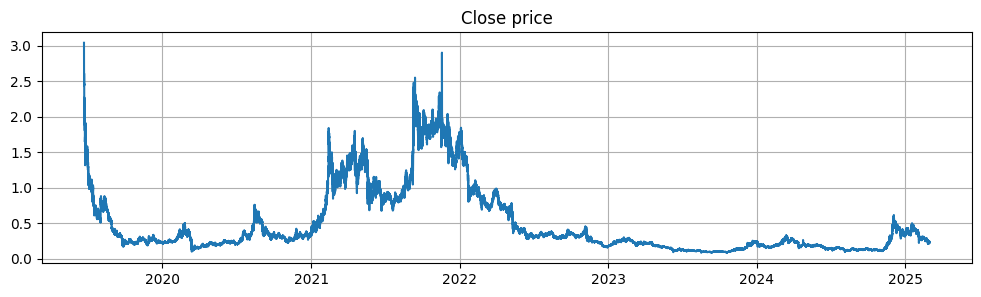

In [40]:
# Plot close price
gen_plot(df_complete['close'], "Close price")

#### Daily Values

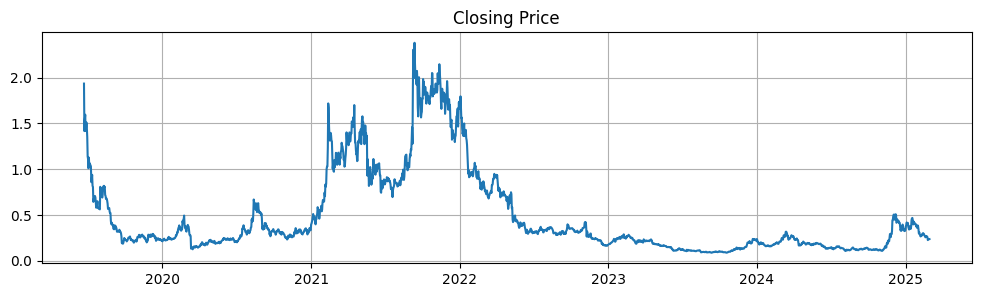

<Figure size 640x480 with 0 Axes>

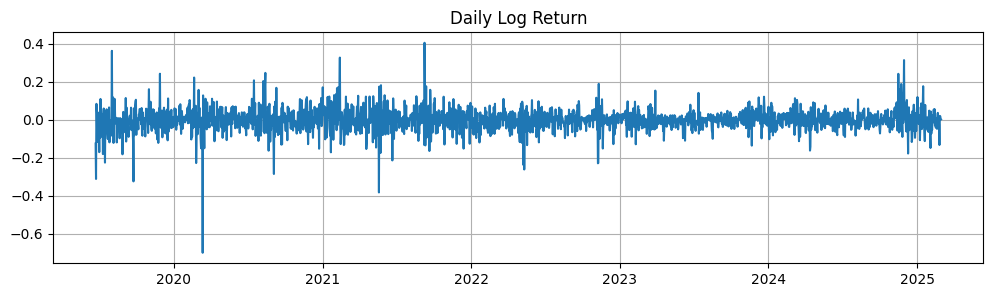

<Figure size 640x480 with 0 Axes>

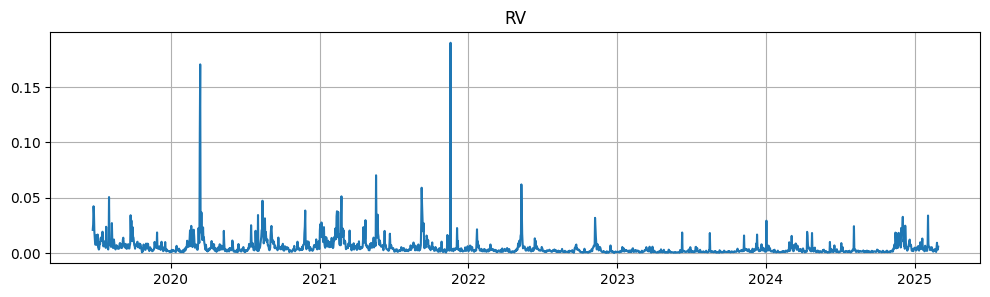

<Figure size 640x480 with 0 Axes>

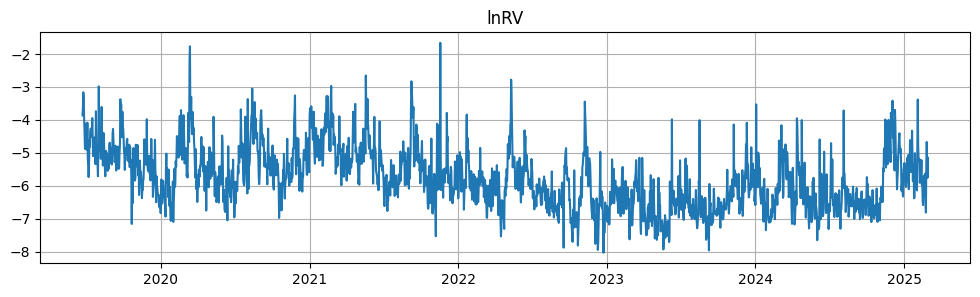

<Figure size 640x480 with 0 Axes>

In [41]:
gen_plot(df_daily['close'], "Closing Price")
plt.savefig('../fig/closing_price.png')
gen_plot(df_daily['return'], "Daily Log Return")
plt.savefig('../fig/daily_log_return.png')
gen_plot(df_daily['RV'], "RV")
plt.savefig('../fig/RV.png')
gen_plot(df_daily['lnRV'], "lnRV")
plt.savefig('../fig/lnRV.png')

### Summary Statistics

In [42]:
import scipy.stats as stats
from statsmodels.tsa.stattools import adfuller

The augmented Dickey–Fuller test (ADF) tests the null hypothesis that a unit root is present in a time series sample.

The Jarque–Bera test is a goodness-of-fit test of whether sample data have the skewness and kurtosis matching a normal distribution. The test statistic is always nonnegative. If it is far from zero, it signals the data do not have a normal distribution.

In [43]:
df_daily.columns

Index(['open', 'high', 'low', 'close', 'return', 'RV', 'lnRV'], dtype='object')

In [44]:
summary_table = pd.DataFrame(index=['mean', 'median', 'std', 'min', 'max', 'skewness', 'kurtosis', 
                                    'ADF', 'ADF p-value', 'JB statistic', 'JB p-value'])

for c in df_daily.columns[:7]:
    summary_table[c] = [df_daily[c].mean(), df_daily[c].median(), df_daily[c].std(),
                        df_daily[c].min(), df_daily[c].max(), df_daily[c].skew(),
                        df_daily[c].kurtosis(), adfuller(df_daily[c])[0], adfuller(df_daily[c])[1], 
                        stats.jarque_bera(df_daily[c]).statistic, stats.jarque_bera(df_daily[c]).pvalue]
print(summary_table.T)
summary_table.T.to_csv('../data/summary_table.csv')

            mean    median       std       min       max   skewness  \
open    0.481266  0.285100  0.463379  0.088600  2.378000   1.715691   
high    0.507257  0.299350  0.494322  0.090400  2.990000   1.748793   
low     0.454925  0.268200  0.434185  0.082000  2.031800   1.714494   
close   0.480336  0.284800  0.461922  0.088700  2.379300   1.714148   
return -0.001069  0.000983  0.061373 -0.700566  0.405569  -0.633221   
RV      0.005113  0.002887  0.008532  0.000325  0.190018  10.721023   
lnRV   -5.770039 -5.847613  0.919468 -8.030840 -1.660635   0.499400   

          kurtosis        ADF   ADF p-value  JB statistic     JB p-value  
open      2.122797  -2.080380  2.524766e-01  1.405230e+03  7.215378e-306  
high      2.368912  -1.871810  3.454363e-01  1.540024e+03   0.000000e+00  
low       2.106639  -1.731687  4.148645e-01  1.397929e+03  2.776705e-304  
close     2.113807  -2.041065  2.688626e-01  1.400122e+03  9.276627e-305  
return   12.491217 -14.393055  8.759231e-27  1.357719e+0

### Histogram and QQ-plot of daily log return series

In [45]:
import statsmodels.api as sm

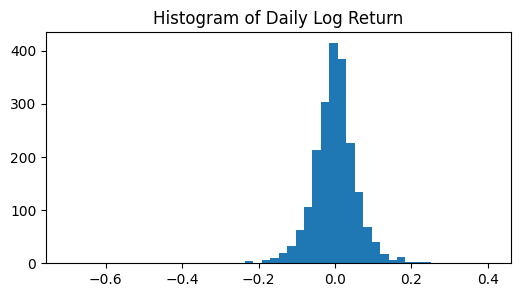

In [51]:
plt.figure(figsize=(6, 3))
plt.hist(df_daily['return'], bins=50)
plt.title('Histogram of Daily Log Return')
plt.savefig('../fig/histogram_daily_log_return.png')
plt.show()

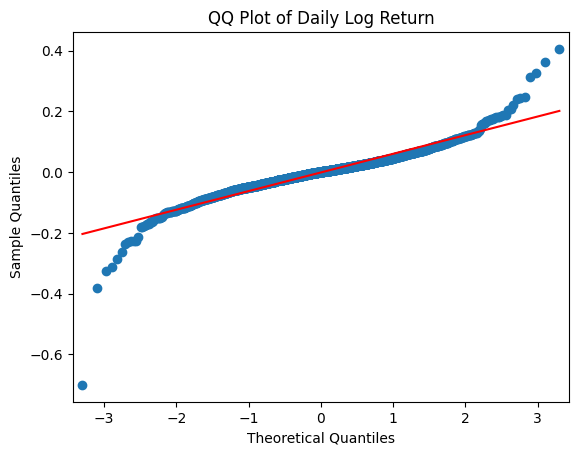

In [52]:
sm.qqplot(df_daily['return'], line ='s')
plt.title('QQ Plot of Daily Log Return')
plt.savefig('../fig/qqplot_daily_log_return.png')
plt.show()

### Histogram and QQ-plot of daily lnRV

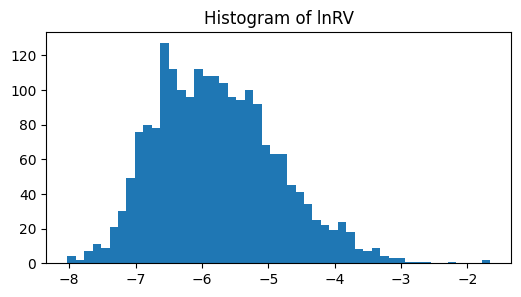

In [53]:
plt.figure(figsize=(6, 3))
plt.hist(df_daily['lnRV'], bins=50)
plt.title('Histogram of lnRV')
plt.savefig('../fig/histogram_lnRV.png')
plt.show()

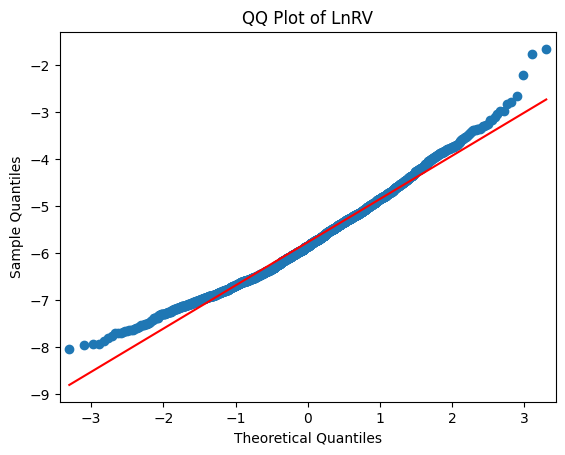

In [54]:
sm.qqplot(df_daily['lnRV'], line ='s')
plt.title('QQ Plot of LnRV')
plt.savefig('../fig/qqplot_lnRV.png')
plt.show()

### Save pre-processed data

In [50]:
df_daily.to_csv('..\data\ALGO_daily.csv')